In [8]:
import glob
import re
import matplotlib.backends.backend_pdf

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.mlab   as mlab
import seaborn           as sns

from scipy       import stats
from prettytable import PrettyTable
from itertools   import product

from scipy.stats import rankdata
from scipy.stats import wilcoxon

# plots 3d
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy import interpolate

sns.set()

plt.style.use('default')
plt.rc('text', usetex=True)


print('Done')

Done


In [4]:
#Configurando as listas que serão percorridas nos plots

dss = [
    'airfoil', 
    'concrete',
    'energyCooling',
    'energyHeating',
     'towerData',
     'wineRed',
     'wineWhite',
     'yacht'
]

_dss_labels = {
    'airfoil'       : 'Airfoil',
    'concrete'      : 'Concrete',
    'energyCooling' : 'Energy Cooling',
    'energyHeating' : 'Energy Heating',
    'towerData'     : 'Tower Data',
    'wineRed'       : 'Wine Red',
    'wineWhite'     : 'Wine White',
    'yacht'         : 'Yacth'
}
 
folds     = 5
reps      = 6

evol_path = './evolution_log/' #'../src/evolution_log/'
grid_path = './grid_log/'      #'../src/grid_log'

save_path = './plots/'

#Aqui devem ter todos os hp que estavam sendo variados no gridsearch
search_params = {
    'expolim'   : [1, 2, 3, 4, 5],
    'max_terms' : [2, 4, 6, 8, 10]    
}

In [43]:
labels      = np.array(['expolim', 'max\_terms'])

def make_radar_chart(ax, name, stats, attribute_labels):

    angles = np.linspace(0, 0.5*np.pi, 2, endpoint=False)
    angles = np.concatenate((angles,[angles[0]]))
    
    for stat in stats:
        
        print(stat)
        stat[0] = [0, 1, 2, 3, 4, 5].index(stat[0])/5.0
        stat[1] = [0, 2, 4, 6, 8, 10].index(stat[1])/5.0
                
        stat  = np.concatenate( (stat, [stat[0]]) )
        
        print(stat)
        ax.plot(angles, stat, '-', c='lightblue', linewidth=1.5)

    ax.set_rgrids(np.linspace(0, 1, 6))    
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_yticklabels([])
    ax.set_title(name)
    ax.grid(True)
    
    for i, s in enumerate([1, 2, 3, 4, 5]):
            ax.annotate(s, fontsize=8, zorder=10,
            xy=[angles[0], (i+1)/5],
            ha="right", va="bottom")

    for i, s in enumerate([2, 4, 6, 8, 10]):
            ax.annotate(s, fontsize=8, zorder=10,
            xy=[angles[1], (i+1)/5],
            ha="left", va="bottom")

        
    return ax

In [13]:
def get_final_rmse_raw(params, ds, metric='rmse_test'):
    #Parecida com a anterior, mas não calcula a média antes de retornar
    final_rmses = []
    
    for f in range(folds):
        for r in range(reps):
            
            resultsDF = pd.read_csv(f'{grid_path}{ds}-{f}-{r}.csv')
            
            for k, v in params.items():
                #Encontrando a métrica, percorrendo cada item do dicionário params
                resultsDF = resultsDF[resultsDF[k]==v]

            #Primeiro passo criando uma matriz com cada convergencia
            final_rmses.append(resultsDF[metric].tolist()[0])
    
            if np.isnan(resultsDF[metric].tolist()[0]):
                print('NaN na configuração', ds, f, r, params)

    return final_rmses

def get_final_rmse_median(params, ds, metric='rmse_test'):
    #Parecida com a anterior, mas só pega o RMSE final, aqui eu busco 
    #nos arquivos do grid_log, que tem todas as métricas (rmse, mae, nmse)
    #e a expressão de melhor fit
    
    #Exemplo de uso: get_final_rmse_mean({'expolim':1, 'max_terms':4}, 'airfoil')
    
    final_rmses = get_final_rmse_raw(params, ds, metric)
    
    
    m = np.median([f for f in final_rmses if not np.isnan(f)], axis=0)
    
    return m

def get_final_rmse_best(params, ds, metric='rmse_test'):

    final_rmses = get_final_rmse_raw(params, ds, metric)
    
    m = np.min(final_rmses)
    
    return m

def dict_string(d):
    #Converte um dicionário para uma string
    
    return '\n'.join([k+'='+str(v) for k, v in d.items()]).replace('expolim', 'degree_range')

def check_pv(arg):
    x, y = arg
    if np.isnan(x) or np.isnan(y):
        return False
    return True


# -------------------------------------------------------
for ds in dss:
    best         = {'expolim': search_params['expolim'][0], 'max_terms':search_params['max_terms'][0]}
    best_median  = get_final_rmse_median(best, ds)
    
    worst        = {'expolim': search_params['expolim'][0], 'max_terms':search_params['max_terms'][0]}
    worst_median = get_final_rmse_median(best, ds)
    
    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
        
    for hp1 in search_params['expolim']:
        for hp2 in search_params['max_terms']:
            
            final_rmse_median = get_final_rmse_median({'expolim':hp1, 'max_terms':hp2}, ds)
            
            if final_rmse_median < best_median:
                best_median = final_rmse_median
                best = {'expolim':hp1, 'max_terms':hp2}
        
        if final_rmse_median > worst_median:
                worst_median = final_rmse_median
                worst = {'expolim':hp1, 'max_terms':hp2}
                
        
                
    print(ds, best, worst)

airfoil {'expolim': 2, 'max_terms': 10} {'expolim': 1, 'max_terms': 2}
NaN na configuração concrete 2 0 {'expolim': 4, 'max_terms': 10}
NaN na configuração concrete 4 4 {'expolim': 4, 'max_terms': 10}
NaN na configuração concrete 0 1 {'expolim': 5, 'max_terms': 10}
NaN na configuração concrete 2 0 {'expolim': 5, 'max_terms': 10}
concrete {'expolim': 3, 'max_terms': 10} {'expolim': 1, 'max_terms': 2}
energyCooling {'expolim': 3, 'max_terms': 10} {'expolim': 1, 'max_terms': 2}
energyHeating {'expolim': 3, 'max_terms': 10} {'expolim': 1, 'max_terms': 2}
towerData {'expolim': 2, 'max_terms': 10} {'expolim': 1, 'max_terms': 2}
wineRed {'expolim': 2, 'max_terms': 6} {'expolim': 1, 'max_terms': 2}
wineWhite {'expolim': 3, 'max_terms': 10} {'expolim': 1, 'max_terms': 2}
yacht {'expolim': 5, 'max_terms': 10} {'expolim': 1, 'max_terms': 2}


[2, 10]
[0.4 1.  0.4]
[3, 10]
[0.6 1.  0.6]
[3, 10]
[0.6 1.  0.6]
[2, 10]
[0.4 1.  0.4]
[2, 6]
[0.4 0.6 0.4]
[3, 10]
[0.6 1.  0.6]
[5, 10]
[1. 1. 1.]
[1, 2]
[0.2 0.2 0.2]
[1, 2]
[0.2 0.2 0.2]
[1, 2]
[0.2 0.2 0.2]
[1, 2]
[0.2 0.2 0.2]
[1, 2]
[0.2 0.2 0.2]
[1, 2]
[0.2 0.2 0.2]
[1, 2]
[0.2 0.2 0.2]
[1, 2]
[0.2 0.2 0.2]


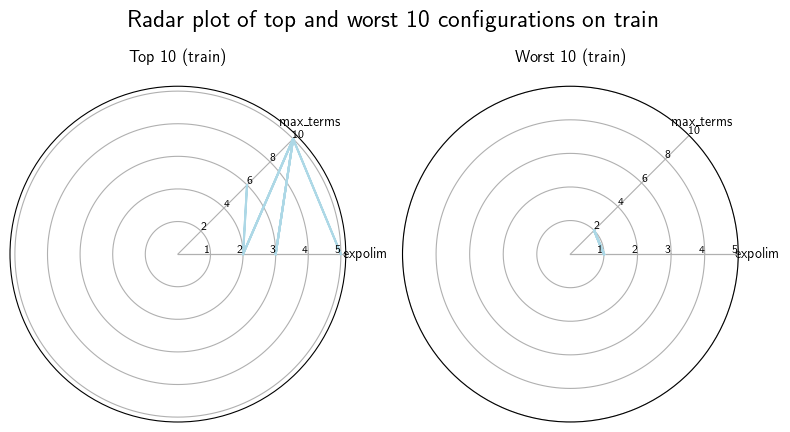

In [44]:
# Fazendo o spider plot

n = 10

# os melhores e piores encontrados para cada base
n_best  = [
    [2, 10],
    [3, 10],
    [3, 10],
    [2, 10],
    [2, 6],
    [3, 10],
    [5, 10]
]

n_worst = [
    [1, 2],
    [1, 2],
    [1, 2],
    [1, 2],
    [1, 2],
    [1, 2],
    [1, 2],
    [1, 2],
]
    
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), subplot_kw={'aspect': 1, 'polar':True})
    
# Top 20
make_radar_chart(axs[0], f'Top {n} (train)', n_best, labels)

make_radar_chart(axs[1], f'Worst {n} (train)', n_worst, labels)

title = f'Radar plot of top and worst {n} configurations on train'
fig.suptitle(title, verticalalignment='top', fontsize = 18)

    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'radar.pdf', bbox_inches='tight')